In [209]:
# Advanced Statistical Machine Learning & Pattern Recognition - CO495
# skeleton for CW1
# Written for Python 3.

In [210]:
import h5py
from scipy.io import savemat
import numpy as np
import csv
import matplotlib.pyplot as plt
import io
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
N=2000
try:
    %matplotlib inline
except NameError:
    # this is a terminal, that's fine.
    pass

(2, 2000)


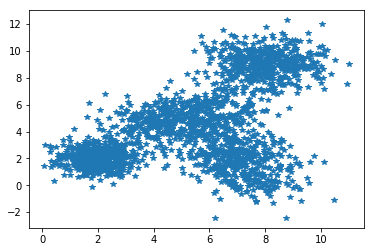

In [211]:
# load the file.
f = h5py.File('X.mat')
f.keys()

X = f.get('X').value
print X.shape
# optionally visualise the X matrix.
try:
    plt.plot(X[0, :], X[1, :], '*')
    
except:
    pass

# EM Init

In [212]:
def EMInit(X, K):
    #params = random_params_generator(K)
    eval_m1 = np.random.rand(2)
    eval_m2 = np.random.rand(2)
    eval_m3 = np.random.rand(2)
    eval_m4 = np.random.rand(2)
    estimator = KMeans(n_clusters=K)
    estimator.fit(X.T)
    centroids,labels= estimator.cluster_centers_,estimator.labels_
    sum_var=np.zeros((4,2,2))
    var=np.zeros((4,2,2))
    for i in range(2000):
        sum_var[labels[i]]+=np.reshape([X[0][i],X[1][i]]-centroids[labels[i]],(2,1))*np.reshape([X[0][i],X[1][i]]-centroids[labels[i]],(1,2))
    for k in range(4):
        var[k]=sum_var[k]/list(labels).count(k)
    params = {}
    for i in range(1, K + 1):
        nn = 'means_{}'.format(i)
        params[nn] = centroids[i-1]
        nn = 'covars_{}'.format(i)
        params[nn] = var[i-1]
        nn = 'mixCoeff_{}'.format(i)
        params[nn] = list(labels).count(i-1)/2000.0
    return params

# EM E step

In [213]:
def EMEStep(X,K,params):
    resp = np.ones((2000,4)) * 0.25
    #create an array 2000(N)*4,every line is 4*0.25
    for n in range(N):
        sum_e_n=0
        for l in range(K):
            sum_e_n += params['mixCoeff_{}'.format(l+1)]*multivariate_normal.pdf([X[0][n],X[1][n]], mean=params['means_{}'.format(l+1)], cov=params['covars_{}'.format(l+1)])
        for k in range(K):
            resp[n][k]=params['mixCoeff_{}'.format(k+1)]/sum_e_n*multivariate_normal.pdf([X[0][n],X[1][n]], mean=params['means_{}'.format(k+1)], cov=params['covars_{}'.format(k+1)])
            #X[0][n],X[1][n] Gaussian prob#
    return resp

# EM M step

In [214]:
def EMMStep(X, K, resp):
    new_params={}
    mixCoeff=np.zeros(4)
    means=np.zeros((4,2))
    covars=np.zeros((4,2,2))
    for k in range(K):
        temp=0
        for n in range(N):
            mixCoeff[k]+=resp[n][k]/N
            temp+=resp[n][k]
        for n in range(N):
            means[k]+=np.array([X[0][n],X[1][n]])*resp[n][k]/temp
        for n in range(N):
            covars[k]+=resp[n][k]*np.reshape(([X[0][n],X[1][n]]-means[k]),(2,1))*np.reshape(([X[0][n],X[1][n]]-means[k]),(1,2))/temp
    for i in range(K):
        nn = 'means_{}'.format(i+1)
        new_params[nn]= means[i]
        nn = 'covars_{}'.format(i+1)
        new_params[nn]=covars[i]
        nn = 'mixCoeff_{}'.format(i+1)
        new_params[nn]=mixCoeff[i]
    return new_params

# GMM Demo

In [215]:
# aux functions
def random_params_generator(K):
    params = {}
    for i in range(1, K + 1):
        nn = 'means_{}'.format(i)
        params[nn] = np.random.rand(2)
        nn = 'covars_{}'.format(i)
        #params[nn] = np.random.rand(2, 2)
        params[nn] = np.array([[1,0.2],[0.2,1]])
        nn = 'mixCoeff_{}'.format(i)
        params[nn] = np.random.rand(1)
    return params


def convert_params_to_row(params, K):
    # accepts the params dict and converts it to a row to be exported.
    # The covars are flattened per row.
    row = []
    for var in ['means', 'covars', 'mixCoeff']:
        for i in range(1, K + 1):
            elems = params['{}_{}'.format(var, i)].flatten()
            row += [str(el) for el in elems]
    return row

In [216]:
def GMMDemo(X, K=4):
    # accepts a 2 dimensional matrix X with the observed 
    # data and the K, which represents the number of clusters.
    # Please do not modify it!
    #
    # initialise the parameters
    params = EMInit(X, K) 
    #B is data matrix here, C is the number of Gaussian Distributions 
    # params should be a dict() with the following format:
    # params['means_[i]'] -> [2x1 float] (i \in [1, K])
    # params['covars_[i]'] -> [2x2 float] (i \in [1, K])
    # params['mixCoeff_[i]'] -> [1x1 float] (i \in [1, K])
    
    # EM algorithm
    # do not change the iterations --- keep them fixed.
    for i  in range(10):
        # E step
        resp = EMEStep(X, K, params); # compute responsibilities, i.e., every \gamma(z_{n,k})
        #resp is an N*K vector
        # M step
        params = EMMStep(X, K, resp) # update the values for the parameters
    #print params
    #return params
    #params is a dict!
    # comment out the line below once you have implemented 
    # the init code!
    #params = random_params_generator(K)
    # save the final values for the parameters
    # savemat('params.mat', {'params' : params})
    # export in csv.
    row = convert_params_to_row(params, K)
    print params
    for r in row:
        r=unicode(r)
    with io.open('params.csv', 'wb') as fn:#Here I make a modificaiton. For my python environment, the original code will 
        #report as an erro show that "write() argument 1 must be unicode, not str". 
        writer = csv.writer(fn)
        writer.writerow(row)
    #print 'done'

In [217]:
GMMDemo(X, K=4)



{'covars_1': array([[ 1.8906865 ,  0.49429292],
       [ 0.49429292,  0.99539668]]), 'covars_3': array([[ 1.06063285, -0.49514593],
       [-0.49514593,  1.85981389]]), 'covars_2': array([[ 1.03323426, -0.00788144],
       [-0.00788144,  0.97366275]]), 'covars_4': array([[ 0.49183114,  0.00589224],
       [ 0.00589224,  0.45876576]]), 'mixCoeff_2': 0.2498260331296627, 'mixCoeff_3': 0.24480085345568717, 'mixCoeff_1': 0.25476283360525526, 'mixCoeff_4': 0.25061027980939476, 'means_4': array([ 1.98717629,  2.00624766]), 'means_1': array([ 5.01663696,  5.02286884]), 'means_2': array([ 7.97655199,  9.07474059]), 'means_3': array([ 7.04324422,  1.89327452])}
